<a href="https://colab.research.google.com/github/Harshitag77/Speed-Typing-Tracer/blob/main/ECG_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imported libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

connecting to the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 256;
BATCH_SIZE = 32;
CHANNELS = 3;

Retrieving the dataset from drive and storing in a variable named dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/drive/MyDrive/Ecg_Images(2)',
   shuffle = True,
   image_size = (IMAGE_SIZE, IMAGE_SIZE),
   batch_size = BATCH_SIZE
)

Found 2924 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['M', 'N', 'Q', 'S', 'V']

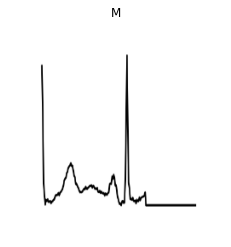

In [ ]:
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[label_batch[1]])           # to get the type(label) of image in the first bactch
  plt.axis("off");    

Printing multiple images from the dataset

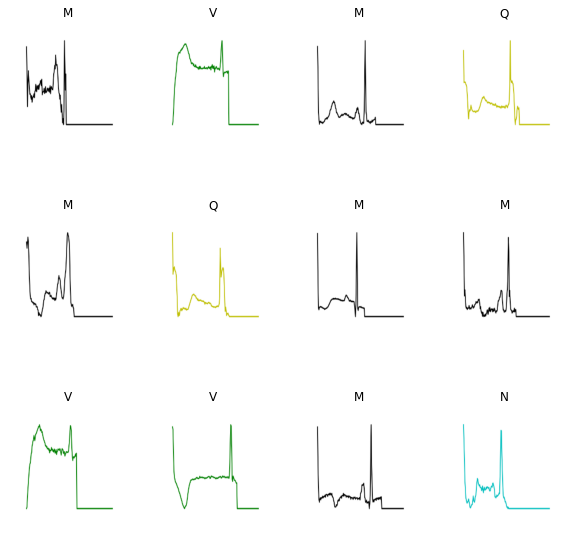

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])           # to get the type of image
      plt.axis("off");                                 #to hide the numbers in x-axis and y 

function to split dataset into train, valdidation and test dataset

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, test_split=0.15, val_split=0.15, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)
  
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds;

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

64

In [ ]:
len(val_ds)

13

In [ ]:
len(test_ds)

15

In [ ]:
# my datasets are kind of optimised for training performance, now the training will go fast
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

defining the layers in the model 

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_class = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # layers.Conv2D(128, (3,3), activation='relu'),
    # layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_class, activation='softmax'),

])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (32, 127, 127, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (32, 125, 125, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 62, 62, 16)         0         
 g2D)                                                 

Compile the code

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='false'),
    metrics=['accuracy']
)

start training

In [ ]:
EPOCHS = 3
# storing in the history so that we can plot some plots later on
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


64/64 [==============================] - 92s 1s/step - loss: 1.3191 - accuracy: 0.5311 - val_loss: 0.5436 - val_accuracy: 0.8029
Epoch 2/3
64/64 [==============================] - 91s 1s/step - loss: 0.1786 - accuracy: 0.9635 - val_loss: 0.0316 - val_accuracy: 1.0000
Epoch 3/3
64/64 [==============================] - 91s 1s/step - loss: 0.0218 - accuracy: 0.9965 - val_loss: 0.0126 - val_accuracy: 1.0000


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

graphical representation of training and valdidation accuracy w.r.t epochs

Text(0.5, 1.0, 'Training and Validation Accuracy')

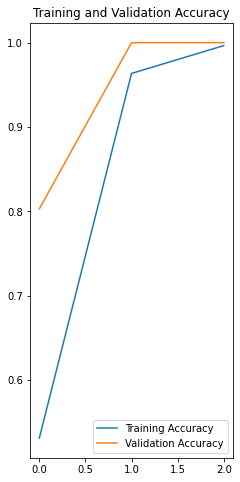

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


predicting the type of heartbeat for one random image from the test dataset

first image to predict
first image's actual label: N
predicted label: N


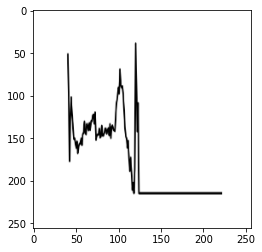

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label] )

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

function to predict the type of heartbeat

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

evaluating the Accuracy on test dataset

In [ ]:
result = model.evaluate(test_ds)

15/15 [==============================] - 8s 514ms/step - loss: 0.0124 - accuracy: 0.9979


Predicting multiple classes in one go

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


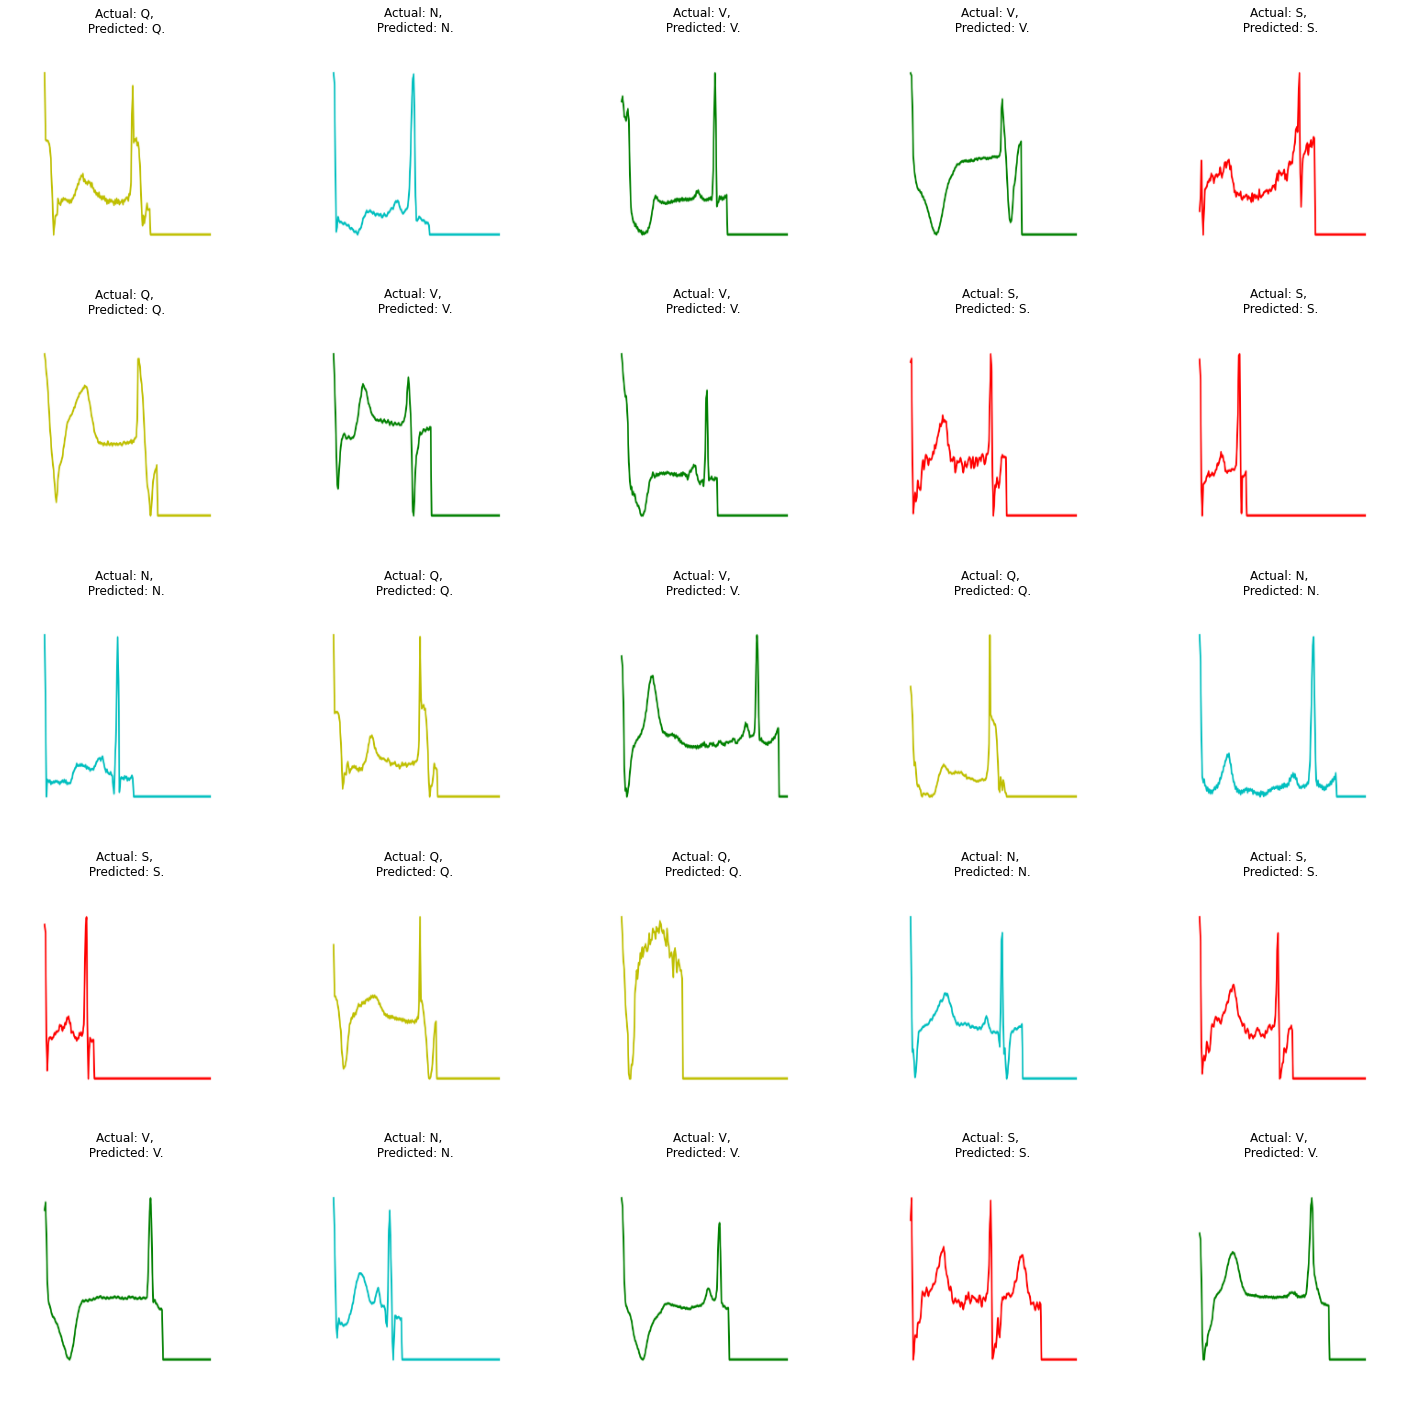

In [ ]:
plt.figure(figsize=(25,25))
for images, labels in test_ds.take(5):
  for i in  range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")

    plt.axis("off")